# RNN architecture implementation from Scratch using pytorch

After reading this notebook you will get the in-depth insight about Recurrent Neural Network (RNN):
1. **what problems of the feed forward Neural Network have RNN solved?**
2. **Understand the RNN architecture and its working mechanism**
3. **Mathematical understanding of forward pass**
4. **How to implement it in pytorch ?**
5. **Limitation of RNN**

## 📢 Prerequisites
Please note that before moving forward, it is better to have the fundamental knowledge of
1. python
2. pytorch
3. feed-forward neural network

## Feed-forward Neural Network (FFNN) and its limitation
If you are familiar with this architecture, then I assume you already know about the feed-forward neural network. It is a simple neural network architecture where data flows in one direction --input to output layer. Please, not that here data flow in one direction does not mean there is no backpropagation, it actually means there is no loops within each or intermediate layers. Don't worry about the "loops", we will come to that later.

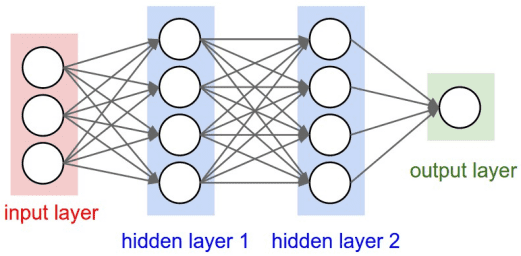

### ⚠️ Limitation of feed-forward neural network over sequential data

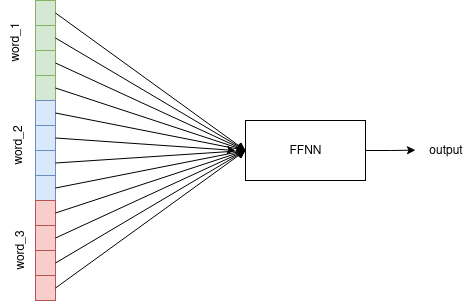

Natural languages or sentences are in a sequential form where order of words in the sentence matters.
For instance, ***"man killed lion"*** and ***"lion killed man"*** has two different meaning. 
1. **Since we pass the entire sentence (input features) at once in FFNN ,there is no information about the orders of input features**
    - FFNN treats input features independently
2. **Fixed input size**
   - sequential data varies in length, for a task of sentence classifier or audio classifier, the input sequence may varies.
   - FFNN expect a fixed length input vector, thus need to add paddings or tuncate the sequence
3. **High dimensionality for long sequence**
   - To handle large sequence, the input feature vector becomes large.As a result model becomes large and training becomes in-efficient.


So to solve the limitation of FFNN, we need to build something that should be capable of taking varying length input size as well as preserve the order of the sequential data. In a simple word, we need to build a model that reads one word at a time from a sentence instead of reading entire sentence at once which FFNN was doing.

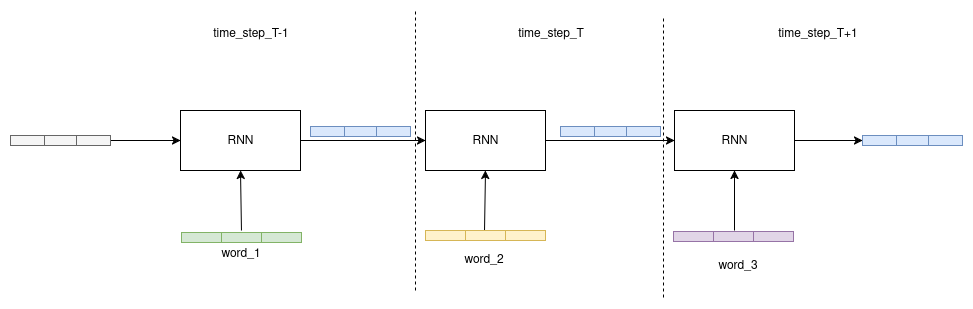

In the above figure, we are passing one word at a time to the model in a loop along with the previous step output. This architecture has solved the previous limitation of the FFNN where instead of passing all the word at once we are passing one word at a time in a loop as well as passing the information from previous step to the next step which basically conveying the information in a sequential order, thus model gets the inforamtion about the order of the words in the sentence.

Here is a pseudo code to understand the idea about time step in the above diagram
```
# ---In FFNN ---------
output = FFNN(sentence)


#------- In RNN --------
prev_out = init_value
for word in sentence:
    out = RNN(word, prev_out)
    prev_out = out
``` 

Now, we need to figure out how to produce output from the previous output and current word. 
One simple approach is we are going to add these two vectors as shown in the figure

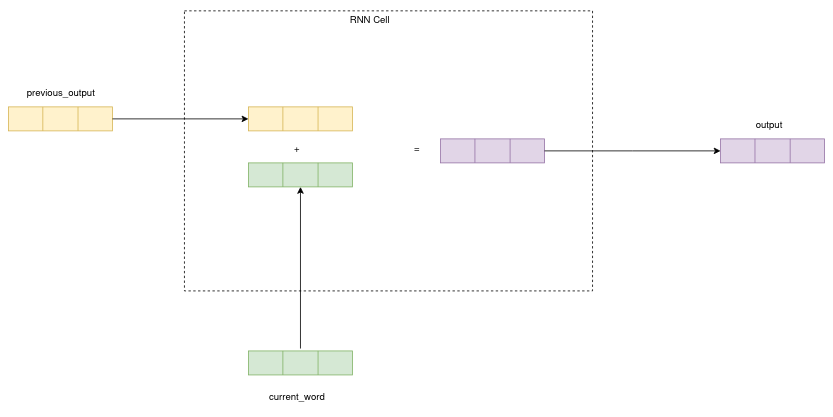

Here we just add the previous output with the current word and return the resultant vector as a current output. But wait a minute there is an issue with this approach:

- both word vector and output vector needs to have the save dimension, otherwise we have to truncate or add padding to make it work
- also the final output is just the sum of all the word vectors and the initial output vector, there is no learning parameter, thus there is no learning.

Now let's overcome these two major issues

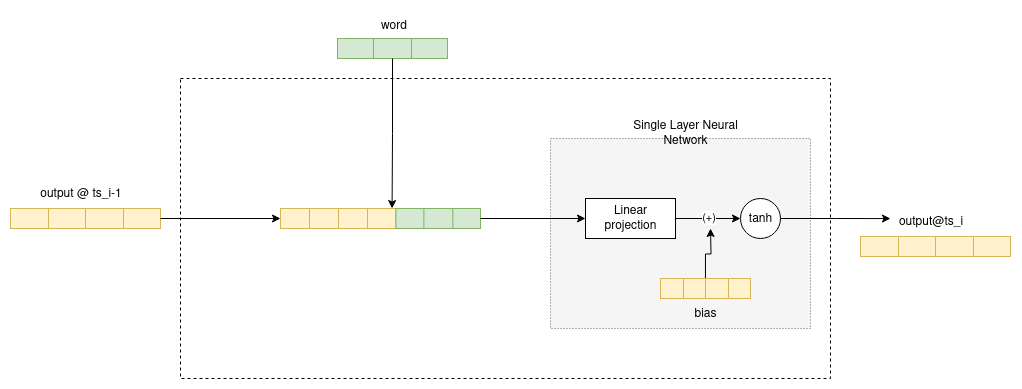

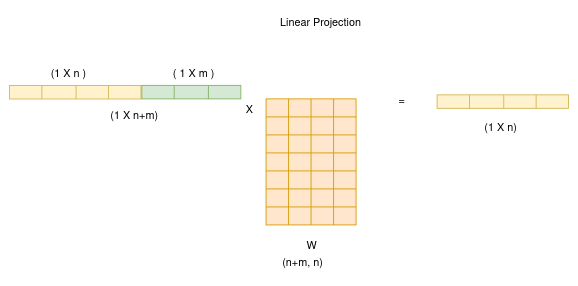

Here, 
- we performed concatenation instead of vector addition, so it can handle different size of word vector and output vector
- we then added a single layer neural network which is learnable as well as project the concatenated vector to a output vector dimension
- We used an activation function "tanh" because it maps the value to the range (-1, 1), that captures Polarity (positive/negative influence)
       - +1 is a positive influence
       - -1 is a negative influence
    - Sigmoid’s gradient max is 0.25, while tanh’s gradient max is 1, meaning less prune to vanishing gradient descent.
    - helps in stable training

congratulations, you have successfully architecture a RNN model. 🎉🥳

# Mathematically
Now let's view the RNN architecture mathematically.

$$
O_t = O_{t-1} W_o + X_t W_i + b
$$
$$
O_t = \tanh(O_t)
$$

Or it can also be written as:

$$
O_t = concat(O_{t-1}, X_t) * W + b 
$$
$$
O_t = \tanh(O_t)
$$

where,

- **O_{t-1} :** output vector of t-1 step -> (batch_size, 1, n)
- **X_t :** current input vector of t step -> (batch_size, 1, m) dim
- **b**: bias vector -> (1, n )
- **W**: weight matrix of shape (n+m, n)
- **O_t**: (batch_size, 1, n) dim output vector of t step

# Sequential Task

We have built the fundamental structure of an RNN architecture, but we still need to understand how to apply it effectively to NLP tasks. In natural language processing, data is inherently sequential, and different tasks require different input-output mappings. Broadly, these tasks can be categorized into the following types:

1. **One-to-Sequence:** A single input maps to a sequence of outputs.
Example: Image captioning, where one image is transformed into a sequence of descriptive words.

2. **Sequence-to-One:** A sequence of inputs maps to a single output.
Example: Document sentiment analysis, where a full sentence or paragraph is classified into positive/negative sentiment.

3. **Sequence-to-Sequence (Seq2Seq):** A sequence of inputs maps to another sequence of outputs.
Example: Machine translation, where an English sentence is translated into its French equivalent.

# Sequence-to-one

In sequence-to-one model, we process all the words(tokens) and use the last output as a prediction of the model.
So far our RNN model will process all the words and but sill does not generate the prediction output. For instance, we need to build a model that predict the sentiment of the given sentence, our model can process all the word and generate a final output vector but this vector does not tell which sentiment class it belongs yet. To make it predict the sentiment class we need to add one extra layer of single layer neural network that projects the final output vector space to the sentiment class space.

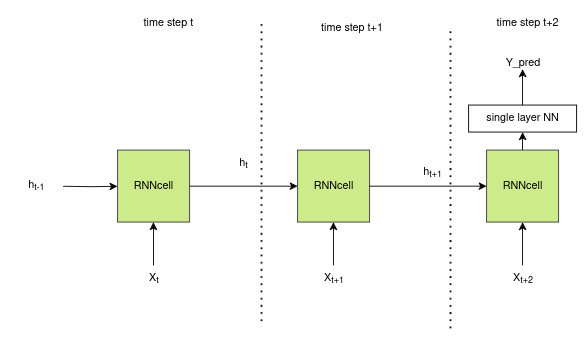

Note that, I have denoted output vector as hidden_state "h" because this is the common practice, also I have denoted word vector as token "X"

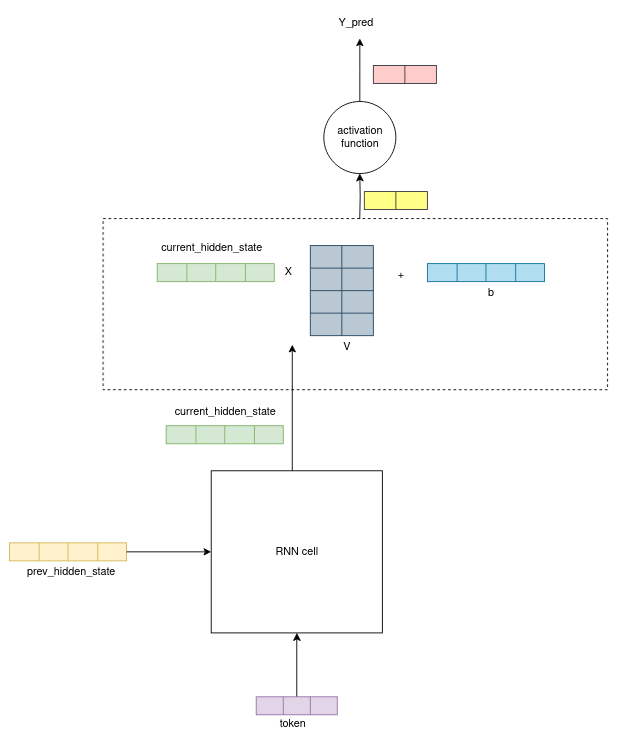

Mathematically it can be written as:

$$
h_t = concat(h_{t-1}, X_t) * W + b 
$$
$$
h_t = tanh(h_t)
$$
$$
y\_pred = activation_function ( h_t * V + b\_)
$$

where,
- activation function is picked based on the task
- V is the weight matrix that project (1 X n) dimension vector into (1 X output_size) vector
- b_ is the bias term of size (1 X output_size) 

Now let's implement it in pytorch, 
- step 1: we need to create a RNN cell which basically takes previous hidden state and the current token as input and return the current hidden state
- step 2: we need to create a RNN architecture that takes sequential input in a batch,
  - pass each token and previous hidden state to the RNN cell at a time 
  - pass output of the RNN cell of each step to the linear layer (single layer neural network) and save the output in a list

so after completion of step 2 we will have the output of each time step, however for seq-to-one task we will only be using the last output. 

## RNN cell

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size): 
        """
        input_size: (int) input vector dimension
        hidden_size: (int) hidden state vector dimension
        """
        
        super(BasicRNNCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # weight input -> hidden layer
        self.W = nn.Parameter(torch.randn(hidden_size+input_size, hidden_size)) 
        # W -> (hidden_size + input_size, hidden_size)
        
        self.b = nn.Parameter(torch.zeros(hidden_size))
        # b -> (hidden_size)
    
    def forward(self, x, h_prev): 
        # X -> (num_batch, input_size)
        # h_prev -> (num_batch, hidden_size)

        # concatinating the previous hidden state and input vector 
        x_h = torch.cat([h_prev, x], axis=1)
        # x_h -> (num_batch, hidden_size+input_size)
        
        linear_proj = torch.matmul(x_h, self.W) + self.b
        # linear_proj -> (num_batch, hidden_size)
        h_new = torch.tanh(linear_proj)
        # h_new -> (num_batch, hidden_size)
        
        return h_new

**1. Weights (W_ih, W_hh, etc.) are already nn.Parameters.**
- When you later call .to(device) or .cuda() on the whole model, all parameters automatically move to that device.
- So you don’t need to do .to(device) for weights manually.

**2. The hidden state is created at runtime (not registered as a parameter).**
- Unlike model weights, h_prev is not part of the model definition—it’s initialized fresh in each forward pass.
- That means you must explicitly place it on the same device as the input.

# Simple RNN model

In [21]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn_cell = BasicRNNCell(input_size, hidden_size)
        self.fcc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq): 
        #input_seq -> (batch_size, seq_length, input_length)
        
        outputs = [] #all time step outputs

        self.batch_size = input_seq.size(0)
        self.seq_length = input_seq.size(1)

        # initialize hidden state for the first time step
        h_prev = torch.zeros(self.batch_size, self.hidden_size).to(input_seq.device)

        for t in range(0, self.seq_length):
            x = input_seq[:, t, :]
            h_prev = self.rnn_cell(x, h_prev)
            # h_prev -> (batch_size, hidden_size)
            # unsqueese h_prev -> (batch_size, 1, hidden_size)
            outputs.append(h_prev.unsqueeze(1))

        
        final_hidden_state = outputs[-1]
        fcc_output = self.fcc(final_hidden_state)
        outputs = torch.cat(outputs, axis=1)
        return outputs, fcc_output

Let's run the Simple RNN with a dummy input 

In [22]:
batch_size = 2
seq_length = 3
input_size = 3
hidden_size = 4
output_size = 2 # for sentiment analysis -> two class positive and negative

x = torch.randn(batch_size, seq_length, input_size)
x

tensor([[[ 1.7365, -1.3399, -2.3343],
         [-1.1259,  0.8529,  0.0859],
         [ 0.2816,  0.1690,  0.5770]],

        [[ 0.0535,  0.7574,  0.8663],
         [ 0.1742,  1.3378,  1.6400],
         [-2.0249, -0.7254, -0.1880]]])

In [23]:
rnn = SimpleRNN(input_size, hidden_size, output_size)

In [24]:
hidden_states, final_output = rnn(x)

In [26]:
hidden_states.shape

torch.Size([2, 3, 4])

From each time step , we are getting 4 dimentional hidden state of batch size 2.

In [27]:
final_output.shape

torch.Size([2, 1, 2])

predicted output from the final step after passing through Single Layer neural network or Fully connected linear layer. Note that we haven't pass it through an activation function because right now we haven't decide the type of task we are going to perform. I hope you get the idea.

## Deep RNN

A Deep Recurrent Neural Network (Deep RNN) is simply a recurrent neural network (RNN) with multiple hidden layers stacked on top of each other.

🔹 **Normal RNN (shallow)**

- Has one hidden layer that processes sequences.
- At each time step, it takes the current input and the previous hidden state, and produces a new hidden state.
- Useful, but can struggle with learning very complex patterns.

🔹 **Deep RNN**

- Instead of one hidden RNN layer, we stack several RNN layers.
- The output (hidden states) of one RNN layer becomes the input for the next layer at the same time step.
- This stacking lets the network learn hierarchical sequence features (low-level → high-level).

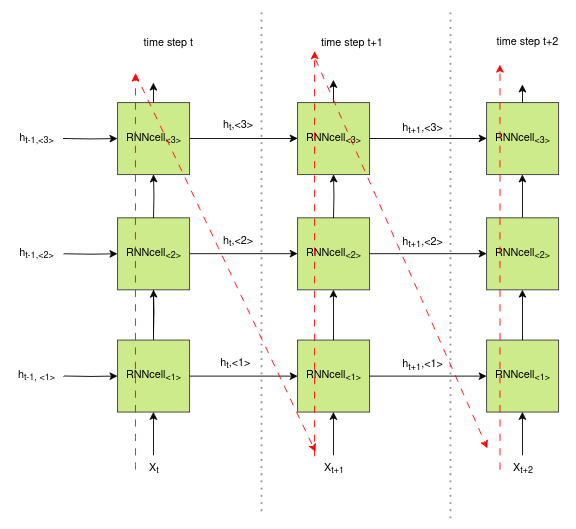

Note that, 
- for each layer there will a different RNNCell. So basically RNNCell<1> != RNNCell<2> != RNNCell<3>
- redline shows the direction of the calculation flow. To compute RNNCell<2>, ht<2>, ht<1> and xt+1 have to be computed already

🔹 What is nn.ModuleList?
- It’s a container for holding submodules (layers) inside your model.
- Works just like a normal Python list, but it’s designed for PyTorch so that all the layers inside it are registered properly as part of the model (so their parameters will be tracked and updated during training

In [29]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(2, 2) for _ in range(3)])

model = MyModel()
print(list(model.parameters()))  

[Parameter containing:
tensor([[ 0.4186, -0.5362],
        [ 0.4938, -0.6649]], requires_grad=True), Parameter containing:
tensor([ 0.6652, -0.7000], requires_grad=True), Parameter containing:
tensor([[-0.6920,  0.0593],
        [ 0.1375, -0.5611]], requires_grad=True), Parameter containing:
tensor([ 0.0795, -0.2327], requires_grad=True), Parameter containing:
tensor([[0.6608, 0.6183],
        [0.6434, 0.2249]], requires_grad=True), Parameter containing:
tensor([0.3378, 0.3471], requires_grad=True)]


In [30]:
class DeepRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """
        input_size = (int) input vector dimension
        hidden_size = (int) hidden state dimension
        output_size = (int) output vector dimension
        num_layers = (int) number of layers of stacked RNN
        """
        
        super(DeepRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # store RNN cells of each layer in a list
        self.rnn_cells = nn.ModuleList()
        for layer_idx in range(self.num_layers):
            layer_input_size = input_size if layer_idx == 0 else hidden_size
            rnn_cell = BasicRNNCell(layer_input_size, hidden_size)
            self.rnn_cells.append(rnn_cell)

        # output layer
        self.fcc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq): 
        #input_seq -> (batch_size, seq_length, input_length)
        outputs = [] #all intermediate hidden_states

        self.batch_size = input_seq.size(0)
        self.seq_length = input_seq.size(1)

        # initialize hidden state for the first time step for each layer
        h_prevs = [torch.zeros(self.batch_size, self.hidden_size).to(input_seq.device)
                   for _ in range(self.num_layers)]

        # h_prevs -> (num_layers, batch_size, hidden_size)
    
        for t in range(0, self.seq_length):
            x = input_seq[:, t, :]

            for layer_idx in range(self.num_layers):
                h_prevs[layer_idx] = self.rnn_cells[layer_idx](x, h_prevs[layer_idx])
                x = h_prevs[layer_idx]
            
            outputs.append(h_prevs[-1].unsqueeze(1)) # saving only the last layer hidden state of each time step
        
        final_hidden_state = outputs[-1]
        fcc_output = self.fcc(final_hidden_state)
        return torch.cat(outputs, axis=1), fcc_output

In [35]:
x = torch.randn(batch_size, seq_length, input_size)
x

tensor([[[-0.7182, -0.6411,  0.9745],
         [-1.0171,  1.0063, -0.7053],
         [ 0.3070, -1.3037,  1.4418]],

        [[ 1.3361, -0.8937, -1.3716],
         [ 0.2207,  1.4129,  0.6570],
         [ 1.0213, -0.3813, -1.3559]]])

In [36]:
num_layers = 2
rnn = DeepRNN(input_size, hidden_size, output_size, num_layers)

In [39]:
hidden_states, final_output = rnn(x)

In [40]:
hidden_states.shape

torch.Size([2, 3, 4])

In [41]:
final_output.shape

torch.Size([2, 1, 2])

In [38]:
print(list(rnn.parameters()))  

[Parameter containing:
tensor([[ 0.4886,  1.8868, -0.1679, -1.1056],
        [-0.8416,  1.5218, -0.6317,  0.0163],
        [-0.1106, -0.8790, -0.3184,  0.3785],
        [ 1.3023, -0.6977,  0.2857,  0.9108],
        [-2.2960,  0.0812, -0.3605,  0.8000],
        [-1.2190, -0.8756,  1.1443, -1.6019],
        [ 0.3904, -1.1045, -0.1359, -1.5732]], requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[ 0.4302,  2.1771,  0.0558,  0.3050],
        [ 2.5212,  0.1803,  1.6110,  0.8977],
        [-0.5270,  0.7955, -1.0678, -1.4707],
        [ 0.2620, -0.2593, -0.1813,  1.8528],
        [-0.1578,  1.5950, -1.1537, -0.3565],
        [ 1.0501,  2.2945,  0.3070,  0.0519],
        [ 0.3369, -0.3524, -1.4200,  1.3902],
        [-0.9045, -0.8588,  1.9540, -0.9020]], requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[ 0.2033,  0.3100, -0.1916, -0.3186],
        [-0.0883,

# Sanity Check
To confirm that out implementation is correct, we are going to traing a model in a toy task where we train the model to predict the next number of the sequence. Here we are not going to care about the overfitting. So there will be only training and evalation.
..checkout the next notebook for sanity checking.